In [323]:
import numpy as np
import matplotlib.pyplot as plt

In [324]:
import torch

def generate_time_series_features_pytorch(n_samples, n_features, n_steps=100, noise_level=0.01):
    """
    Generates a synthetic time series dataset with n_samples and n_features using PyTorch.
    
    Parameters:
    - n_samples: int, the number of samples to generate.
    - n_features: int, the number of features (time series) to generate for each sample.
    - n_steps: int, the number of time steps for each feature.
    - noise_level: float, the level of noise to add to the time series.
    
    Returns:
    - A tuple of PyTorch tensors: (features, target) where
      features is of shape (n_samples, n_steps, n_features) representing the generated time series data,
      and target is a tensor for the target variable.
    """
    # Time axis for the sine wave
    time = torch.linspace(0, 2 * torch.pi, n_steps)
    
    # Generate sine waves for each feature and sample
    features = torch.stack([torch.stack([torch.sin(time + 4*torch.rand(1) * 2 * torch.pi) for _ in range(n_samples)]).T for _ in range(n_features)], dim=2).permute(1, 0, 2)    
    # Add noise
    features += torch.randn(features.shape) * noise_level
    
    # Example target calculation (modify according to your needs)
    # Calcul de la cible en combinant les caractéristiques
    # Exemple : une combinaison linéaire des caractéristiques avec des poids arbitraires
    weights = torch.tensor([1, 1, 1])  # Poids pour 3 caractéristiques, ajustez selon le nombre de caractéristiques
    if n_features >= 3:
        target = features[:, :, 0] * weights[0] + features[:, :, 1] * weights[1] + features[:, :, 2] + weights[2]
        #la target sera simplement la valeur finale du vecteur target
        target = torch.mean(target, dim=1)
    else:
        # Si moins de 3 caractéristiques, utilisez une logique différente ou ajustez les poids
        target = features[:, :, 0]  # Fallback simple si moins de 3 caractéristiques

    return features, target

In [325]:
#print if cuda is available
print(torch.cuda.is_available())

True


600
torch.Size([600, 30, 3])


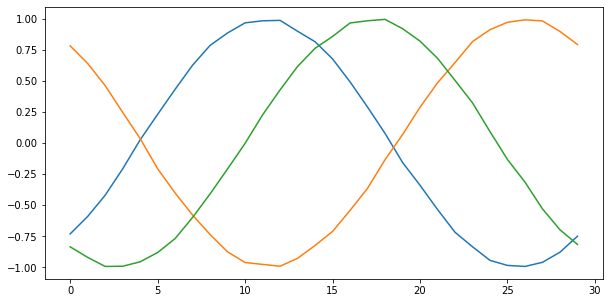

In [326]:
features, target = generate_time_series_features_pytorch(n_features=3, n_steps=30, noise_level=0.01, n_samples=600)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(features.shape[2]):
    ax.plot(features[0, :, i], label=f'Feature {i+1}')
print(len(target)) 
print(features.shape)

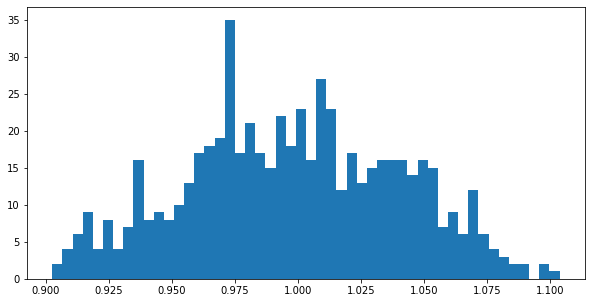

In [327]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
c = ax.hist(target, bins=50)

In [328]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supposons que `features` est votre ensemble de données [samples, time_steps, features]
# Calculer les moyennes et écarts-types pour chaque caractéristique
scaler = StandardScaler()

# Redimensionner les données pour la normalisation: [samples*time_steps, features]
num_samples, num_time_steps, num_features = features.shape
features_reshaped = features.reshape(-1, num_features)

scaler.fit(features_reshaped)  # Fit sur l'ensemble d'entraînement

# Appliquer la normalisation
features_normalized = scaler.transform(features_reshaped)

# Remettre les données dans leur forme originale
features_normalized = features_normalized.reshape(num_samples, num_time_steps, num_features)

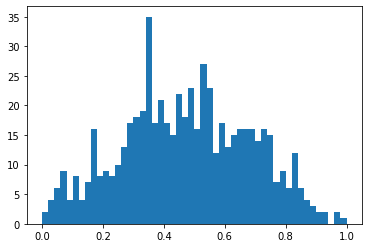

In [329]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Supposons que `target` est votre ensemble de cibles [samples,]
# Redimensionner `target` en une matrice 2D [samples, 1] pour le MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_2d = target.reshape(-1, 1)

# Adapter le scaler à la cible redimensionnée
target_scaler.fit(target_2d)

# Appliquer la normalisation à la cible redimensionnée
target_normalized = target_scaler.transform(target_2d)
c = plt.hist(target_normalized, bins=50)

In [330]:
features_normalized.shape

(600, 30, 3)

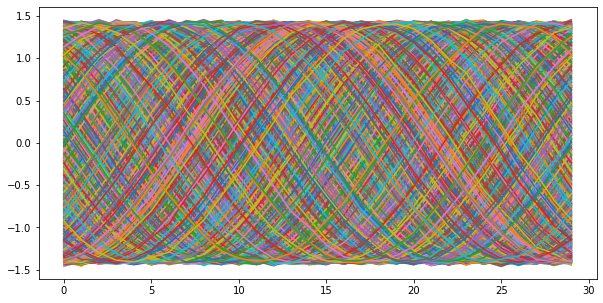

In [331]:
#plot normalized features features_normalized 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(features_normalized.shape[0]):
    ax.plot(features_normalized[i, :, :], label=f'Feature {i+1}')

In [332]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Ajouter l'argument num_layers pour spécifier le nombre de couches LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialiser l'état caché et l'état de la cellule
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # x de forme: [batch_size, seq_len, input_dim]
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Sélectionner la dernière sortie temporelle pour chaque séquence
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

# Exemple d'utilisation avec 2 couches LSTM
# input_dim = 3, hidden_dim = 50, output_dim = 1, num_layers = 2
model = LSTMModel(input_dim=3, hidden_dim=30, output_dim=1, num_layers=10)

In [333]:
# 4. Entraîner le modèle
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [334]:
model

LSTMModel(
  (lstm): LSTM(3, 30, num_layers=10, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

In [335]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [336]:
from sklearn.model_selection import train_test_split


Epoch 1, Improved R²: -0.7242900133132935
Epoch 2, Improved R²: -0.13305461406707764
Epoch 3, Improved R²: -0.09061062335968018
Epoch 4, Improved R²: 0.008285582065582275
Epoch 5, Improved R²: -0.02866804599761963
Epoch 6, Improved R²: -0.0498889684677124
Epoch 7, Improved R²: -0.030474066734313965
Epoch 8, Improved R²: -0.0018030405044555664
Epoch 9, Improved R²: 0.008201837539672852
Epoch 10, Improved R²: -0.0025507211685180664
Epoch 11, Improved R²: -0.012955665588378906
Epoch 13, Improved R²: 0.0030608177185058594
Epoch 17, Improved R²: -0.007586359977722168
Epoch 20, Improved R²: 0.006842613220214844
Epoch 26, Improved R²: 0.02562582492828369
Epoch 27, Improved R²: 0.04619473218917847
Epoch 28, Improved R²: 0.09653949737548828
Epoch 29, Improved R²: 0.21228301525115967
Epoch 30, Improved R²: 0.3412262797355652
Epoch 31, Improved R²: 0.6652346253395081
Epoch 32, Improved R²: 0.6041355729103088
Epoch 33, Improved R²: 0.33894163370132446
Epoch 34, Improved R²: 0.6732814311981201
Epoc

Text(0.5, 0, 'Epoch')

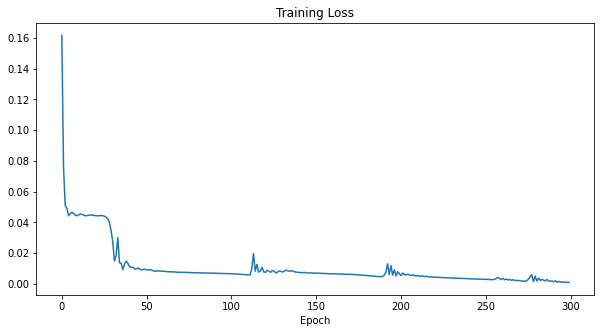

In [337]:
# Supposons que `features_normalized` et `target_normalized` sont vos données Numpy
# Convertir `features_normalized` en un tenseur PyTorch
model = model.to(device)

features_train, features_test, target_train, target_test = train_test_split(
features_normalized, target_normalized, test_size=0.2, random_state=42)



# Convertir en tenseurs PyTorch et envoyer au dispositif approprié
features_train_tensor = torch.tensor(features_train, dtype=torch.float).to(device)
target_train_tensor = torch.tensor(target_train, dtype=torch.float).to(device)
features_test_tensor = torch.tensor(features_test, dtype=torch.float).to(device)
target_test_tensor = torch.tensor(target_test, dtype=torch.float).to(device)

# Initialiser les paramètres pour l'arrêt anticipé
patience = 100  # Nombre d'époques à attendre après la dernière amélioration de la perte de validation
best_loss = np.inf
epochs_no_improve = 0
n_epochs = 300
loss_save = []
# Boucle d'entraînement avec arrêt anticipé
best_r2 = float('-inf')  # Initialiser le meilleur R² comme étant le plus petit nombre possible
epochs_no_improve_r2 = 0  # Compteur pour les époques sans amélioration significative du R²

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(features_train_tensor)
    loss = criterion(y_pred, target_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(features_test_tensor)
        val_loss = criterion(y_val_pred, target_test_tensor)
        # Calcul du R² sur l'ensemble de validation
        r2_val = 1 - val_loss / torch.var(target_test_tensor)

    # Vérifier si le R² de validation s'est amélioré de 0.1
    if torch.abs(r2_val - best_r2) > 0.01:
        best_r2 = r2_val
        epochs_no_improve_r2 = 0
        print(f'Epoch {epoch + 1}, Improved R²: {best_r2.item()}')
    else:
        epochs_no_improve_r2 += 1
        if epochs_no_improve_r2 == patience:
            print(f'Early stopping! Epoch {epoch + 1}, Best R²: {best_r2.item()}')
            break  # Arrêt anticipé

    # Optionnel: Enregistrer la perte d'entraînement pour visualisation
    loss_save.append(loss.item())

# Visualisation de la perte d'entraînement
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(loss_save)
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')

In [338]:
# Passage en mode évaluation
model.eval()

with torch.no_grad():  # Assurez-vous qu'aucun gradient n'est calculé
    predictions_test = model(features_test_tensor)
    predictions_train = model(features_train_tensor)

# Calcul de l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse_test = torch.mean((predictions_test - target_test_tensor) ** 2)
print(f'MSE sur l\'ensemble de test: {mse_test.item()}')

# Calcul du R² sur l'ensemble de test
r2_test = 1 - mse_test / torch.var(target_test_tensor)
print(f'R² sur l\'ensemble de test: {r2_test.item()}')

MSE sur l'ensemble de test: 0.0018696056213229895
R² sur l'ensemble de test: 0.9583866000175476


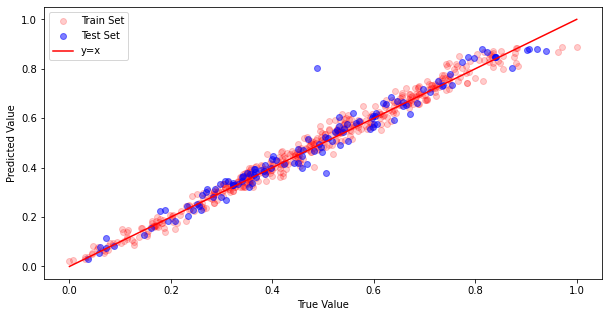

In [339]:
import matplotlib.pyplot as plt

# Conversion des prédictions et des vraies valeurs en CPU pour l'affichage
predictions_np = predictions_test.cpu().numpy()
target_np = target_test_tensor.cpu().numpy()

prediction_train_np = predictions_train.cpu().numpy()
target_train_np = target_train_tensor.cpu().numpy()

# Affichage des prédictions vs les vraies valeurs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(target_train_np, prediction_train_np, alpha=0.2, label='Train Set', color='red')
ax.scatter(target_np, predictions_np, alpha=0.5, label='Test Set', color='blue')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
#add y = x line 
x = np.linspace(0, 1, 100)
y = x
ax.plot(x, y, '-r', label='y=x')
ax.legend()